In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import History

from keras.preprocessing.text import Tokenizer
from keras import layers
from keras.layers import Embedding
from keras.layers.core import Reshape, Flatten
from keras.models import Sequential, Model
from keras.layers import Dense, Activation
from keras.layers import Flatten, Conv1D, SpatialDropout1D, MaxPooling1D,AveragePooling1D, merge, concatenate, Input, Dropout

from wordcloud import WordCloud, STOPWORDS

### read data

In [ ]:
df = pd.read_csv('/content/drive/My Drive/data/dataset.csv', delimiter = ',')

In [ ]:
# Maximum number of words to be embedded
NUM_WORDS = 30000
EMBEDDING_DIM=100
# max length to be encoded for a sentence
MAX_SEQUENCE_LENGTH = 1000

# Define Tokenize text function
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)

# Fit the function on the text
tokenizer.fit_on_texts(df['text'])

sequences = tokenizer.texts_to_sequences(df['text'])

# pad the data to the same length
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

# Count number of unique tokens
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 186361 unique tokens.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, df[['label']], test_size=0.2, random_state=42)

### glove embedding

In [ ]:
word_vectors = dict()

# load the whole embedding into memory
f = open('/content/drive/My Drive/data/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_vectors[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(word_vectors))

Loaded 400000 word vectors.


In [ ]:
vocabulary_size=min(len(word_index)+1,(NUM_WORDS))
#vocabulary_size= len(word_index)+1
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
      # if the word is not found, set to all 0s
        vec = np.zeros(EMBEDDING_DIM)
        embedding_matrix[i]=vec

#del(word_vectors)

In [ ]:
# Dfine Embedding function using the embedding_matrix
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [ ]:
embedding_matrix.shape

(30000, 100)

In [ ]:
X_train.shape

(40986, 1000)

In [ ]:
del(embedding_matrix)

### tokenized with LogisticRegression

In [ ]:
model = Sequential()
model.add(Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))  

model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(4))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='Adadelta', 
              metrics=['acc'])
history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=10, verbose=1)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1000, 100)         3000000   
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 997, 128)          51328     
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 249, 128)          0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 249, 128)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 31872)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               4079744   
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)              

KeyError: ignored

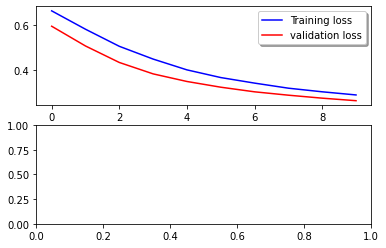

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
# define model
model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['acc'])
# summarize the model
model.summary()
# fit the model
model.fit(X_train,y_train,epochs = 2,validation_data=(X_test, y_test), batch_size=128, verbose = 1)
loss,accuracy = model.evaluate(X_test,y_test)
print('Accuracy: %f' % (accuracy*100))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         3000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 100001    
Total params: 3,100,001
Trainable params: 100,001
Non-trainable params: 3,000,000
_________________________________________________________________
Epoch 1/2
321/321 [==============================] - 9s 27ms/step - loss: 0.3829 - acc: 0.8630 - val_loss: 0.1897 - val_acc: 0.9387
Epoch 2/2
321/321 [==============================] - 2s 7ms/step - loss: 0.1632 - acc: 0.9449
Accuracy: 94.486189


### FNDNet

In [ ]:
num_kernels = 128
kernel_sizes= [3,4,5]
pool_sizes = [800,799,798]

#embed_input = Input(shape=(max_length,))
#x = Embedding(vocab_size,output_dim,input_length=max_length)(embed_input)

inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embed_input = embedding_layer(inputs)

pool_outputs = []
for i in range(len(kernel_sizes)):
    conv = Conv1D(num_kernels, kernel_size=kernel_sizes[i], padding='valid', activation='relu')(embed_input)
    pool = MaxPooling1D(pool_size=pool_sizes[i], strides=1, padding = 'valid')(conv)         
    pool_outputs.append(pool)
merge = concatenate(pool_outputs,axis = 1)

conv = Conv1D(num_kernels, kernel_size=5, activation='relu')(merge)
pool = MaxPooling1D(pool_size=5)(conv)
conv = Conv1D(num_kernels, kernel_size=5, activation='relu')(pool)
pool = MaxPooling1D(pool_size=30)(conv)

x = Flatten()(pool)
#x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs,outputs=x)
model.summary() 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1000, 100)    3000000     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 998, 128)     38528       embedding[2][0]                  
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 997, 128)     51328       embedding[2][0]                  
____________________________________________________________________________________________

In [ ]:
model.compile(loss='binary_crossentropy',
              #optimizer='Adadelta',
              optimizer='Adam',
              metrics=['acc'])

In [ ]:
from keras.utils import to_categorical
y_train = to_categorical(np.asarray(y_train))
y_test = to_categorical(np.asarray(y_test))

In [ ]:
epochs = 20
batch_size = 128

model.fit(X_train,y_train,epochs = epochs,validation_data=(X_test, y_test), batch_size=batch_size, verbose = 1)

Epoch 1/20
321/321 [==============================] - 50s 156ms/step - loss: 0.7178 - acc: 0.5064 - val_loss: 0.6774 - val_acc: 0.6127
Epoch 2/20
321/321 [==============================] - 51s 159ms/step - loss: 0.6809 - acc: 0.5619 - val_loss: 0.6600 - val_acc: 0.6596
Epoch 3/20
321/321 [==============================] - 51s 158ms/step - loss: 0.6616 - acc: 0.6108 - val_loss: 0.6422 - val_acc: 0.6974
Epoch 4/20
321/321 [==============================] - 51s 158ms/step - loss: 0.6426 - acc: 0.6509 - val_loss: 0.6246 - val_acc: 0.7462
Epoch 5/20
321/321 [==============================] - 51s 158ms/step - loss: 0.6231 - acc: 0.6902 - val_loss: 0.6046 - val_acc: 0.7626
Epoch 6/20
321/321 [==============================] - 51s 159ms/step - loss: 0.6046 - acc: 0.7206 - val_loss: 0.5862 - val_acc: 0.7862
Epoch 7/20
321/321 [==============================] - 51s 159ms/step - loss: 0.5862 - acc: 0.7486 - val_loss: 0.5677 - val_acc: 0.8064
Epoch 8/20
321/321 [==============================] - 5

In [ ]:
epochs = 2
batch_size = 128

model.fit(X_train,y_train,epochs = epochs,validation_data=(X_test, y_test), batch_size=batch_size, verbose = 1)
loss,accuracy = model.evaluate(X_test,y_test)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/2
321/321 [==============================] - 204s 541ms/step - loss: 0.3404 - acc: 0.8376 - val_loss: 0.0906 - val_acc: 0.9646
Epoch 2/2
321/321 [==============================] - 17s 54ms/step - loss: 0.0602 - acc: 0.9763
Accuracy: 97.628576


In [ ]:
epochs = 20
batch_size = 128

model.fit(X_train,y_train,epochs = epochs,validation_data=(X_test, y_test), batch_size=batch_size, verbose = 1)
#loss,accuracy = model.evaluate(X_test,y_test)
#print('Accuracy: %f' % (accuracy*100))

Epoch 1/20
321/321 [==============================] - 50s 156ms/step - loss: 0.7383 - acc: 0.5163 - val_loss: 0.6670 - val_acc: 0.6059
Epoch 2/20
321/321 [==============================] - 51s 160ms/step - loss: 0.6803 - acc: 0.5754 - val_loss: 0.6337 - val_acc: 0.6805
Epoch 3/20
321/321 [==============================] - 51s 159ms/step - loss: 0.6430 - acc: 0.6288 - val_loss: 0.6072 - val_acc: 0.7336
Epoch 4/20
321/321 [==============================] - 51s 159ms/step - loss: 0.6132 - acc: 0.6759 - val_loss: 0.5820 - val_acc: 0.7642
Epoch 5/20
321/321 [==============================] - 51s 159ms/step - loss: 0.5812 - acc: 0.7212 - val_loss: 0.5528 - val_acc: 0.7951
Epoch 6/20
321/321 [==============================] - 51s 159ms/step - loss: 0.5543 - acc: 0.7543 - val_loss: 0.5270 - val_acc: 0.8128
Epoch 7/20
321/321 [==============================] - 51s 159ms/step - loss: 0.5282 - acc: 0.7785 - val_loss: 0.5027 - val_acc: 0.8261
Epoch 8/20
321/321 [==============================] - 5